# Dask Queue-based Progress Bar Demo

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from qprogress import progress, compute_with_progress, log

In [3]:
from dask.distributed import Client, Queue
client = Client(n_workers=20, threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 20
Total threads: 20,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44225,Workers: 20
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:33979,Total threads: 1
Dashboard: http://127.0.0.1:33648/status,Memory: 50.38 GiB
Nanny: tcp://127.0.0.1:44779,


Something to compute:

In [4]:
def some_fun(v):
    from qprogress import log
    log('prog1', int(v))
    return v

def some_fun2(v):
    from qprogress import log
    log('prog2', int(v))
    return v

def setup_computation():
    import numpy as np
    import dask.bag as db
    from dask.distributed import Queue
    
    vals = np.arange(3000)

    b = ( 
        db
         .from_sequence(vals)
         .map(some_fun)
         .map(lambda x: [x, 2*x])
         .flatten()
         .map(some_fun2)
        )
    
    return b, [len(vals), 2*len(vals)]

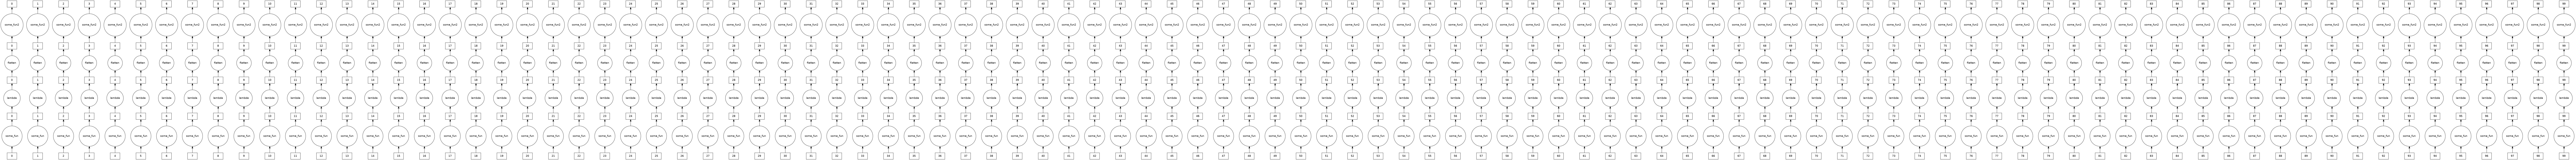

In [5]:
b, (len1, len2) = setup_computation()
b.visualize()

### The common case

In [6]:
result = compute_with_progress(b)
len(result), sum(result)

prog1: 0it [00:00, ?it/s]

prog2: 0it [00:00, ?it/s]

(6000, 13495500)

### Specify length

In [7]:
result = compute_with_progress(b, config=dict(prog1=dict(desc=" First map", total=len1), prog2=dict(desc="Second map", total=len2)))
len(result), sum(result)

 First map:   0%|          | 0/3000 [00:00<?, ?it/s]

Second map:   0%|          | 0/6000 [00:00<?, ?it/s]

(6000, 13495500)

### Use the tqdm-like iterator interface

Here, we monitor only one key.

In [10]:
from itertools import accumulate
prog = progress(b, total=len2)
for total in accumulate(prog):
    prog.set_postfix_str(f'Rows loaded: {total: 12,d}', refresh=False)
result = prog.result()

prog1:   0%|          | 0/6000 [00:00<?, ?it/s]

prog2:   0%|          | 0/6000 [00:00<?, ?it/s]

### tqdm-like iterator interface for multiple queues

In [13]:
prog = progress(b, kv=True).config('prog1', total=len1).config('prog2', total=len2)
totals = dict(prog1=0, prog2=0)
for k, v in prog:
    totals[k] += v
    prog.set_postfix_str(f'Rows loaded: {totals[k]: 12,d}', refresh=False)
result = prog.result()

prog1:   0%|          | 0/3000 [00:00<?, ?it/s]

prog2:   0%|          | 0/6000 [00:00<?, ?it/s]